In [1]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import re
import os
%matplotlib inline

# Define paths

Accross the analysis the following names are used for the 3 screens
- ova == Hippo RNAi Ovariole Number screen
- fec == Hippo RNAi EggLaying screen
- xRNAi == EggLaying screen

In [2]:
# Define the path where all the primary data are

data = '../Data/'

# Load the datasets

In [3]:
# Loading the raw data for the 3 screens
# HippoRNAi EggLaying
hipo_fec = pd.read_csv(os.path.join(data,'Screen', 'Raw', 'Raw_EggLaying_HpoRNAi.csv'))
# HippoRNAi Ovariole Number
hipo_ova = pd.read_csv(os.path.join(data,'Screen', 'Raw', 'Raw_Ova_HpoRNAi.csv'))
# Egg Laying
xRNAi_fec = pd.read_csv(os.path.join(data,'Screen', 'Raw', 'Raw_EggLaying.csv'))

# And we load the signaling table that contains the mapping for all the FbID to signaling pathway
signaling = pd.read_csv(os.path.join(data,'signaling.csv'))

## Checking that we have the correct number of genes

In [4]:
# Assert that the number of gene in the screen, that are in the signaling table (which contains the gene tested) is 463
assert (len(hipo_fec[hipo_fec['FbID'].isin(signaling['FbID'])]['FbID'].unique()) == 463)

In [5]:
# Assert that the number of gene in the screen, that are in the signaling table (which contains the gene tested) is 273
assert len(hipo_ova[hipo_ova['FbID'].isin(signaling['FbID'])]['FbID'].unique()) == 273

In [6]:
# Assert that the number of gene in the screen, that are in the signaling table (which contains the gene tested) is 273
assert len(xRNAi_fec[xRNAi_fec['FbID'].isin(signaling['FbID'])]['FbID'].unique()) == 273

# Cleaning Ovariole Number data
## Tidy Data for Ovariole Database

In [7]:
# Create the mapping table for Fly ID to column name
map_FlyId = {'Fly 1':1,
             'Fly 1.1':1,
             'Fly 2':2,
             'Fly 2.1':2,
             'Fly 3':3,
             'Fly 3.1':3,
             'Fly 4':4,
             'Fly 4.1':4,
             'Fly 5':5,
             'Fly 5.1':5,
             'Fly 6':6,
             'Fly 6.1':6,
             'Fly 7':7,
             'Fly 7.1':7,
             'Fly 8':8,
             'Fly 8.1':8,
             'Fly 9':9,
             'Fly 9.1':9,
             'Fly 10':10,
             'Fly 10.1':10
            }

In [8]:
# Here we Tidy the data, aka we transform the 2 entry table into a tidy dataframe format
# Create an array to hold the reults

result = []
# For each row
for i in range(len(hipo_ova)):
    # collect meta information 
    FbID = hipo_ova['FbID'][i]
    Condition = hipo_ova['Condition'][i]
    batch = hipo_ova['BATCH'][i]
    # For each ovary
    for ovary in map_FlyId:
        # Define FlyID
        FlyID = map_FlyId[ovary]
        # Collect ovariole number
        ovanb = hipo_ova[ovary][i]
        # Add the result as a new line to the result array
        result.append([Condition, batch, FbID, FlyID, ovanb])
        
# Save the array into a dataframe 
hipo_ova_clean = pd.DataFrame(result, columns=['Gene', 'Batch','FbID','FlyId','OvarioleNb'])

In [9]:
#Assert that all the rows have been succesfully converted
# 341 rows and 20 measurement points -> 6820
assert(len(hipo_ova_clean) == 6820)

In [10]:
#Assert that we have 273 unique FbID in the table
assert(len(hipo_ova_clean['FbID'].unique()) == 273 + 1) # +1 for the control genes -> NaN

In [11]:
# Test that we have data for all ovaries for all the flies
for gene in hipo_ova_clean['FbID'].unique():
    assert(len(hipo_ova_clean[hipo_ova_clean['FbID']==gene]) % 20 == 0)

## Z Score calculation

In [12]:
# We select only the control data
control = hipo_ova_clean[hipo_ova_clean['Gene'] == 'Tj>HpoRNAi']

In [13]:
# We should have 13 controls in this dataset
assert(len(control)/20 == 13)

In [14]:
# Here we calculate the mean ovariole number for each batch
# We group the dataset by batch, then we calculate the mean for each group 
# considering each ovary an independant variable
# Then we reset the index to have a clean dataframe
control_mean = control.groupby(['Batch']).mean().reset_index()
# And the same for the standard deviation
control_std = control.groupby(['Batch']).std().reset_index()

In [15]:
# Making sure we have 7 controls for the 7 batches
assert(len(control_mean) == 7)

In [16]:
# Now we calculate the Z score for all the non control values

# Define an array to hold our Z scores
Zs = []
# For each line of our tidy table
for i in range(len(hipo_ova_clean)):
    # Get the batch value
    batch = hipo_ova_clean['Batch'][i]
    # get the ovariole nb counts
    count = hipo_ova_clean['OvarioleNb'][i]
    # Get the mean value for the batch
    mu = control_mean[control_mean['Batch'] == batch]['OvarioleNb'].values[0]
    # Get the std for the batch
    std = control_std[control_std['Batch'] == batch]['OvarioleNb'].values[0]
    # Calculate Z as Z = x-mu / std
    Z = (count-mu)/std
    # save Z
    Zs.append(Z)

In [17]:
hipo_ova_clean['Z'] = Zs

## Saving results

In [18]:
hipo_ova_clean.to_csv(os.path.join(data,'Screen', 'hipo_ova_clean.csv'), index=False)

# Cleaning Egg Laying Hippo RNAi
## Tidy Data for Ovariole Database

In [19]:
hipo_fec['Sum'] = hipo_fec['Day 1'] + hipo_fec['Day 2 '] + hipo_fec['Day 3'] + hipo_fec['Day 4 '] + hipo_fec['Day 5']

In [20]:
Conditions = ['Day 1',
 'Day 2 ',
 'Day 3',
 'Day 4 ',
 'Day 5',
 'Sum']

In [21]:
results = []
for i in range(len(hipo_fec)):
    condition = hipo_fec['Condition'][i]
    batch = hipo_fec['BATCH'][i]
    FbID = hipo_fec['FbID'][i]
    for c in Conditions:
        count = hipo_fec[c][i]
        results.append([condition, batch, FbID, c, count])                          
hipo_fec_clean = pd.DataFrame(results, columns=['Gene', 'Batch', 'FbID', 'Condition', 'Count'])

In [22]:
#Assert that all the rows have been succesfully converted
# 592 rows and 5 measurement points and the sum -> 592 * (5+1) = 3552
assert(len(hipo_fec_clean) == 3552)

In [23]:
#Assert that we have 463 unique FbID in the table
assert(len(hipo_fec_clean['FbID'].unique()) == 463 + 1) # +1 for the control genes -> NaN

In [24]:
# Test that we have data for all datapoints for all the flies
for gene in hipo_fec_clean['FbID'].unique():
    assert(len(hipo_fec_clean[hipo_fec_clean['FbID']==gene]) % 6 == 0)

## Z Score calculation

In [25]:
control = hipo_fec_clean[hipo_fec_clean['Gene'] == 'Tj>HpoRNAi']

In [26]:
# We should have 13 controls in this dataset
assert(len(control)/6 == 44)

In [27]:
# Here we group again by batch AND by condition this time and calculate the mean and std
control_mean = control[['Batch','Condition','Count']].groupby(['Batch','Condition']).mean().reset_index()
control_std = control[['Batch','Condition','Count']].groupby(['Batch','Condition']).std().reset_index()

In [28]:
# Making sure we have 9 controls for the 9 batches * 6 condition
assert(len(control_mean) == 9*6)

In [29]:
# exact same code as above for Z score
res = []
for i in range(len(hipo_fec_clean)):
    batch = hipo_fec_clean['Batch'][i]
    condition = hipo_fec_clean['Condition'][i]
    count = hipo_fec_clean['Count'][i]
    mu = control_mean[(control_mean['Batch'] == batch) & (control_mean['Condition'] == condition)]['Count'].values[0]
    std = control_std[(control_std['Batch'] == batch) & (control_std['Condition'] == condition)]['Count'].values[0]
    Z = (count-mu)/std
    res.append(Z)

In [30]:
hipo_fec_clean['Z'] = res

## Saving results

In [31]:
hipo_fec_clean.to_csv(os.path.join(data,'Screen', 'hipo_fec_clean.csv'), index=False)

# Cleaning Egg Laying
## Tidy Data for Ovariole Database

In [32]:
xRNAi_fec['Sum'] = xRNAi_fec['Day 1'] + xRNAi_fec['Day 2 '] + xRNAi_fec['Day 3'] + xRNAi_fec['Day 4 '] + xRNAi_fec['Day 5']

In [33]:
Conditions = ['Day 1',
 'Day 2 ',
 'Day 3',
 'Day 4 ',
 'Day 5',
 'Sum']

In [34]:
results = []
for i in range(len(xRNAi_fec)):
    condition = xRNAi_fec['Condition'][i]
    batch = xRNAi_fec['BATCH'][i]
    FbID = xRNAi_fec['FbID'][i]
    for c in Conditions:
        count = xRNAi_fec[c][i]
        results.append([condition, batch, FbID, c, count])                          
xRNAi_fec_clean = pd.DataFrame(results, columns=['Gene', 'Batch', 'FbID', 'Condition', 'Count'])

In [35]:
#Assert that all the rows have been succesfully converted
# 355 rows and 6 measurement points -> 2130
assert(len(xRNAi_fec_clean) == 2130)

In [36]:
#Assert that we have 273 unique FbID in the table
assert(len(xRNAi_fec_clean['FbID'].unique()) == 273 + 1) # +1 for the control genes -> NaN

In [37]:
# Test that we have data for all egglay for all the flies
for gene in xRNAi_fec_clean['FbID'].unique():
    assert(len(xRNAi_fec_clean[xRNAi_fec_clean['FbID']==gene]) % 6 == 0)

In [38]:
control = xRNAi_fec_clean[xRNAi_fec_clean['Gene'] == 'Tj>']

In [39]:
# We should have 13 controls in this dataset
assert(len(control)/6 == 27)

In [40]:
control_mean = control[['Batch','Condition','Count']].groupby(['Batch','Condition']).mean().reset_index()
control_std = control[['Batch','Condition','Count']].groupby(['Batch','Condition']).std().reset_index()

In [41]:
res = []
for i in range(len(xRNAi_fec_clean)):
    batch = xRNAi_fec_clean['Batch'][i]
    condition = xRNAi_fec_clean['Condition'][i]
    count = xRNAi_fec_clean['Count'][i]
    mu = control_mean[(control_mean['Batch'] == batch) & (control_mean['Condition'] == condition)]['Count'].values[0]
    std = control_std[(control_std['Batch'] == batch) & (control_std['Condition'] == condition)]['Count'].values[0]
    Z = (count-mu)/std
    res.append(Z)

In [42]:
xRNAi_fec_clean['Z'] = res

## Saving results

In [43]:
xRNAi_fec_clean.to_csv(os.path.join(data,'Screen', 'xRNAi_fec_clean.csv'), index=False)

# Selecting genes above and below Zscore threshold

In [19]:
# We load the CSV files we just created
hipo_ova = pd.read_csv(os.path.join(data, 'Screen', 'hipo_ova_clean.csv'))
hipo_fec = pd.read_csv(os.path.join(data, 'Screen', 'hipo_fec_clean.csv'))
xRNAi_fec = pd.read_csv(os.path.join(data, 'Screen', 'xRNAi_fec_clean.csv'))

In [20]:
# Next we calculate all the Zscore means 
# We group the dataset by gene (FbID) and we take the mean for each.

# Ovariole number screen
mean_ova_gene = hipo_ova.groupby('FbID', as_index=False).mean()

# Here we only consider the sum of egg layed for 5 days

# Hippo RNAi Egg Laying screen
mean_fec_gene = hipo_fec[hipo_fec['Condition'] == 'Sum'].groupby('FbID', as_index=False).mean()

# Egg Laying Screen
mean_xRNAi_gene = xRNAi_fec[xRNAi_fec['Condition'] == 'Sum'].groupby('FbID', as_index=False).mean()


## Define threshold

In [21]:
# We define the thresholds for selecting a candidate 
# Ovariole number at 2 and EggL at 5
ova_threshold = 2
eggl_threshold = 5

In [22]:
# Ovariole number screen
# Keep only genes with a Zscore over or equal to 2
Zposneg_ova = mean_ova_gene[(mean_ova_gene['Z'].abs()>=ova_threshold)]['FbID'].values
# Filter out the controls
Zposneg_ova = [i for i in Zposneg_ova if 'FBgn' in i]

# Hippo RNAi Egg Laying screen
# Keep only genes with a Zscore over or equal to 5
Zposneg_fec = mean_fec_gene[(mean_fec_gene['Z'].abs()>=eggl_threshold)]['FbID'].values
# Filter out the controls
Zposneg_fec = [i for i in Zposneg_fec if 'FBgn' in i]

# Egg Laying Screen
# Keep only genes with a Zscore over or equal to 5
Zposneg_xRNAi = mean_xRNAi_gene[(mean_xRNAi_gene['Z'].abs()>=eggl_threshold)]['FbID'].values
# Filter out the controls
Zposneg_xRNAi = [i for i in Zposneg_xRNAi if 'FBgn' in i]

In [23]:
print("Ovariole number positive candidates:", len(Zposneg_ova))
print("Hippo RNAi Egg Laying positive candidates:", len(Zposneg_fec))
print("Egg Laying positive candidates:", len(Zposneg_xRNAi))

Ovariole number positive candidates: 67
Hippo RNAi Egg Laying positive candidates: 59
Egg Laying positive candidates: 49


In [49]:
assert(len(Zposneg_ova) == 67)
assert(len(Zposneg_fec) == 59)
assert(len(Zposneg_xRNAi) == 49)

## Let's make a table of the candidate genes

In [50]:
resultpath = '../Results'

In [51]:
results = []

In [52]:
# We take the interesection of the positive canditate of the 3 screens. 
core_genes = set.intersection(set(Zposneg_ova), set(Zposneg_fec), set(Zposneg_xRNAi))

In [53]:
for gene in Zposneg_ova:
    results.append(['HpoOvariole', gene])
for gene in Zposneg_fec:
    results.append(['HpoEggL', gene])
for gene in Zposneg_xRNAi:
    results.append(['EggL', gene])
for gene in core_genes:
    results.append(['Core', gene])

In [54]:
df = pd.DataFrame(results, columns=['Screen', "Gene"])

In [55]:
df.to_csv(os.path.join(resultpath, 'Candidate_Above_Z_Threshold.csv'))

## Making the background preditction graph

In [62]:
screen_background_pred = [
    ["EggL", len(Zposneg_xRNAi)/(len(mean_xRNAi_gene['FbID'].unique()) - 1)],
    ["HpoEggL", len(Zposneg_fec)/(len(mean_fec_gene['FbID'].unique()) - 1)],
    ["Ova#", len(Zposneg_ova)/(len(mean_ova_gene['FbID'].unique()) - 1)]
]

In [64]:
screen_background_pred = pd.DataFrame(screen_background_pred, columns=['Screen', 'Prediction Rate'])

In [65]:
screen_background_pred

,Screen,Prediction Rate
0,EggL,0.179487
1,HpoEggL,0.127430
2,Ova#,0.245421


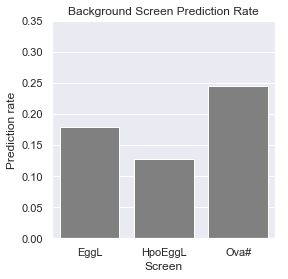

In [67]:
fig = plt.figure(figsize=(4,4))
sns.barplot(data=screen_background_pred, x='Screen', y='Prediction Rate', color="Gray")
plt.title("Background Screen Prediction Rate")
plt.ylabel('Prediction rate')
plt.ylim(0,0.35)
fig.savefig(os.path.join(resultpath, "Background_Pred_Module_rate.svg"))
fig.savefig(os.path.join(resultpath, "Background_Pred_Module_rate.png"))
fig.savefig(os.path.join(resultpath, "Background_Pred_Module_rate.pdf"))